<a href="https://colab.research.google.com/github/yeyevtushenko/AI/blob/Lesson03.04.2024/Lesson03_04_2024_AI_P_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [3]:
import pandas as pd

Дані про розпад протонів

[посилання](https://www.kaggle.com/datasets/fedesoriano/multijet-primary-dataset)

In [4]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/MultiJetRun2010B.csv')

df = df[df['nBJets'] != 2]

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

Дані погано збалансовані

In [5]:
df['nBJets'].value_counts()

nBJets
0    20615
1     1056
Name: count, dtype: int64

In [6]:
df.head()

,Run,Lumi,Event,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets,nBJets
0,0.082072,0.0,0.000002,0.077191,0.041860,0.044618,0.342725,0.531326,0.480732,0.055588,0.696681,0.457241,0.440224,0.061659,0.043047,0.0,0
1,0.082072,0.0,0.000006,0.052182,0.055190,0.018690,0.493614,0.585784,0.491979,0.017684,0.567978,0.430552,0.474613,0.025133,0.034687,0.0,0
2,0.082072,0.0,0.000015,0.154156,0.035263,0.101251,0.540018,0.671386,0.470196,0.273968,0.533484,0.338381,0.325311,0.165718,0.059381,0.2,0
3,0.082072,0.0,0.000048,0.106599,0.123328,0.063472,0.306290,0.523352,0.483465,0.039306,0.713922,0.422854,0.493248,0.101707,0.108566,0.0,0
4,0.082072,0.0,0.000063,0.072599,0.024611,0.383563,0.508826,0.564737,0.292545,0.224039,0.550834,0.433906,0.361549,0.110721,0.018941,0.2,0


Потрібно на основі інформації про розпад спрогнозувати наявність високоенергетичного випромінювання `nBJets`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [7]:
import torch
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

# Завдання 2
Створіть DataLoader

In [8]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values)
      self.y = torch.FloatTensor(y.values)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['nBJets'])
y = df['nBJets']

dataset = MyDataset(X, y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=y
                                                    )

dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

In [10]:
y_train.value_counts()

nBJets
0    16491
1      845
Name: count, dtype: int64

# Завдання 3
Створіть нейромережу

In [11]:
from torch.utils.data import DataLoader

batch_size = 512
train_dl = DataLoader(dataset_train,
                      batch_size=batch_size,
                      shuffle=True
                      )

test_dl = DataLoader(dataset_test,
                     batch_size=batch_size,
                     shuffle=True
                     )

In [12]:
import numpy as np
from torch import nn
import torch.nn.functional as F


class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.linear = nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim // 2)
        self.linear2 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 4)
        self.linear3 = nn.Linear(hidden_dim // 4, hidden_dim // 8)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 8)
        self.linear4 = nn.Linear(hidden_dim // 8, hidden_dim // 16)
        self.bn4 = nn.BatchNorm1d(hidden_dim // 16)
        self.linear5 = nn.Linear(hidden_dim // 16, hidden_dim // 32)
        self.bn5 = nn.BatchNorm1d(hidden_dim // 32)

        self.linear6 = nn.Linear(hidden_dim // 32, output_dim)

    def forward(self, x):
        out = self.linear(x)
        out = self.bn(out)
        out = F.relu(out)
        out = F.dropout(out, 0.2)

        out = self.linear1(out)
        out = self.bn1(out)
        out = F.relu(out)
        #out = F.dropout(out, 0.2)

        out = self.linear2(out)
        out = self.bn2(out)
        out = F.relu(out)
        #out = F.dropout(out, 0.2)

        out = self.linear3(out)
        out = self.bn3(out)
        out = F.relu(out)
        #out = F.dropout(out, 0.2)

        out = self.linear4(out)
        out = self.bn4(out)
        out = F.relu(out)
        #out = F.dropout(out, 0.2)

        out = self.linear5(out)
        out = self.bn5(out)
        out = F.relu(out)
        #out = F.dropout(out, 0.2)

        out = self.linear6(out)
        out = F.sigmoid(out)

        return out

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
          y_pred = self.forward(X)

        return y_pred.numpy()


model = BinaryClassifier(16, 100, 1)
model

BinaryClassifier(
  (linear): Linear(in_features=16, out_features=100, bias=True)
  (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=100, out_features=50, bias=True)
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=50, out_features=25, bias=True)
  (bn2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=25, out_features=12, bias=True)
  (bn3): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=12, out_features=6, bias=True)
  (bn4): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear5): Linear(in_features=6, out_features=3, bias=True)
  (bn5): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear6): Linear(in_features=3, out_features=1, bias=True)
)

In [13]:
from torchsummary import summary

summary(model, input_size=(16,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]           1,700
       BatchNorm1d-2                  [-1, 100]             200
            Linear-3                   [-1, 50]           5,050
       BatchNorm1d-4                   [-1, 50]             100
            Linear-5                   [-1, 25]           1,275
       BatchNorm1d-6                   [-1, 25]              50
            Linear-7                   [-1, 12]             312
       BatchNorm1d-8                   [-1, 12]              24
            Linear-9                    [-1, 6]              78
      BatchNorm1d-10                    [-1, 6]              12
           Linear-11                    [-1, 3]              21
      BatchNorm1d-12                    [-1, 3]               6
           Linear-13                    [-1, 1]               4
Total params: 8,832
Trainable params: 8

# Завдання 4
Визначте функцію втрат та оптимізатор, можливо графік швидкості навчання

In [14]:
class WeightedBCE(nn.Module):
    def __init__(self, pos_weight, neg_weight=1):
        super(WeightedBCE, self).__init__()
        self.neg_weight = neg_weight
        self.pos_weight = pos_weight

    def forward(self, input, target):
        assert input.shape == target.shape, "The loss function received invalid input shapes"
        y_hat = input
        loss = -1.0 * (self.pos_weight * target * torch.log(y_hat + 1e-6) + self.neg_weight * (1 - target) * torch.log(1 - y_hat + 1e-6))
        # Account for 0 times inf which leads to nan
        loss[torch.isnan(loss)] = 0
        # We average across each of the extra attribute dimensions to generalize it
        loss = loss.mean(dim=1)
        # We use mean reduction for our task
        return loss.mean()


In [15]:
# Функція втрат середньоквадратичної помилки (MSE) для регресії
loss_fn = WeightedBCE(20)

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

In [16]:
from torch.optim.lr_scheduler import StepLR

#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Завдання 5
Натренуйте нейромережу.

In [17]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['lr'] = []
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        #scheduler.step()
        #history['lr'].append(scheduler.get_last_lr())


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history


In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_dl, test_dl,
                epochs=20,
                metrics=[accuracy_score, roc_auc_score],
                device=device,
                task='binary')

train() called: model=BinaryClassifier, opt=Adam(lr=0.010000), epochs=20, device=cpu

Epoch    1    1sec	loss:       1.35	val_loss:       1.34	accuracy_score:      0.792	val_accuracy_score:      0.537	roc_auc_score:      0.517	val_roc_auc_score:      0.506	
Epoch    2    1sec	loss:       1.33	val_loss:       1.33	accuracy_score:      0.438	val_accuracy_score:      0.475	roc_auc_score:      0.552	val_roc_auc_score:      0.541	
Epoch    3    1sec	loss:       1.32	val_loss:       1.34	accuracy_score:      0.552	val_accuracy_score:      0.702	roc_auc_score:      0.572	val_roc_auc_score:      0.531	
Epoch    4    1sec	loss:       1.32	val_loss:       1.34	accuracy_score:      0.477	val_accuracy_score:      0.436	roc_auc_score:      0.568	val_roc_auc_score:      0.545	
Epoch    5    1sec	loss:       1.32	val_loss:       1.33	accuracy_score:       0.47	val_accuracy_score:      0.598	roc_auc_score:      0.576	val_roc_auc_score:      0.552	
Epoch    6    1sec	loss:       1.32	val_loss:       1.

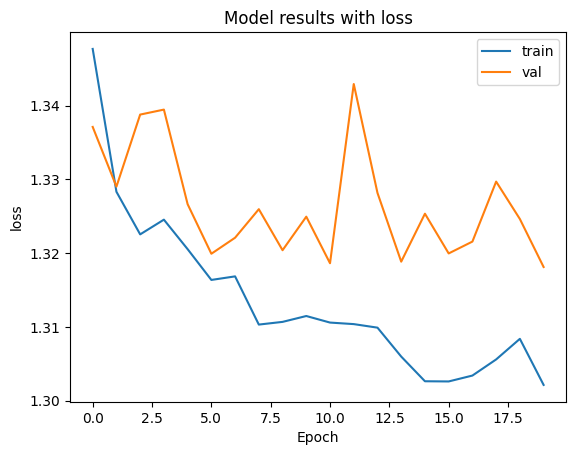

In [19]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

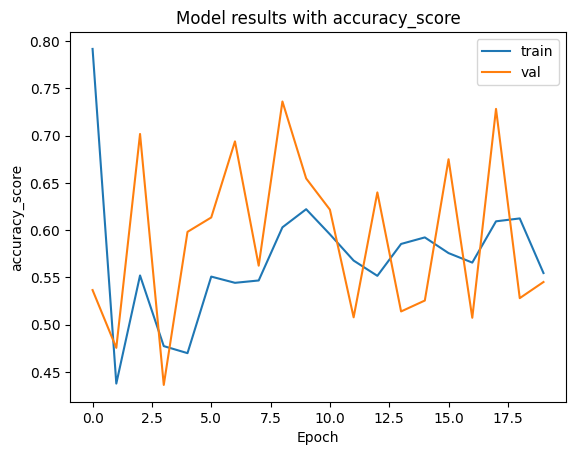

In [20]:
plot_metric(history, 'accuracy_score')

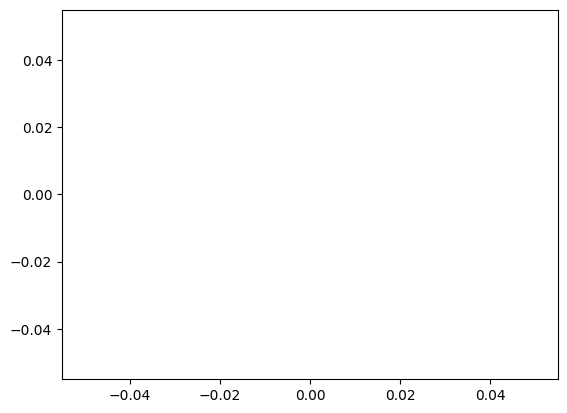

In [21]:
plt.plot(history['lr'])

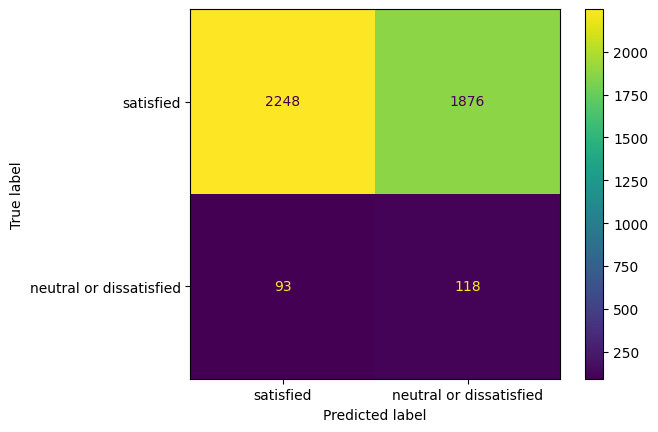

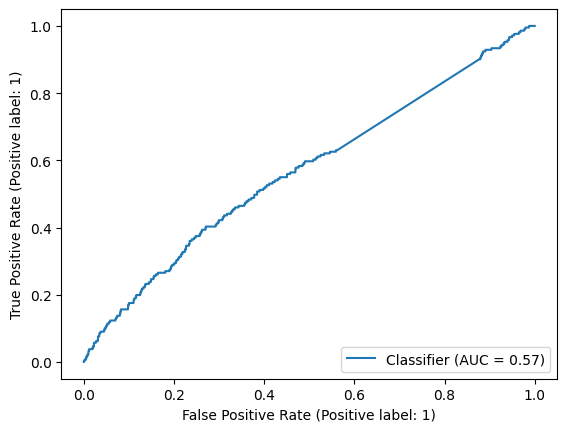

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

model = model.to('cpu')  # відключаємо від gpu
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round(),
                                        display_labels=['satisfied', 'neutral or dissatisfied'])
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [23]:
torch.save(model, 'model.pt')
load_model = torch.load('model.pt')

In [24]:
y_test.values[3]

0

In [25]:
X_data = torch.FloatTensor(X_test.values[[3]])
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[0.0821, 0.0049, 0.0042, 0.2717, 0.0015, 0.1721, 0.4958, 0.5043, 0.4123,
         0.1570, 0.5806, 0.4873, 0.5631, 0.0920, 0.0108, 0.2000]])
torch.Size([1, 16])


In [26]:
load_model(X_data).round().item()

0.0